## Online Marketplace App Challenge: Detecting Spam in Product Listings
Summit Bhalla   
Walkthrough of bag-of-words approach

In [1]:
import pandas as pd
import numpy as np
import cPickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os.path

file_path = os.path.dirname(os.path.realpath('__file__'))
raw_train = os.path.join(file_path,'data/train_set.csv')
raw_test = os.path.join(file_path, 'data/test_set.csv')

## Data Exploration & Cleaning
_____
- First look at the raw data in a beautified df :)

In [ ]:
df = pd.read_csv(raw_train)
df.head()

** ----Output Truncated for Data Privacy Purposes---- **

### Initial observations:
- Won't need the first index column as the DF will manage indices
- (Obviously) the title and description will be predictive of spam / ham classification. My first impression is that the other fields hold less predictive power...
- Immediately see missing values in the first entry. Will need to look for other missing values...
- Text fields will need to be encoded in utf-8. Will only include text that is part of the ascii character set.

In [4]:
null_features = df.isnull().sum()
null_features

Unnamed: 0        0
product_id        1
seller_id         1
title             1
description       1
meet_up        7398
mailing        7398
condition      8417
price             1
class             1
dtype: int64

- There's at least one value that is null in each of the columns. That sucks.
- There's a high number of nulls for the meet_up, mailing and condition features.

In [5]:
df[df.product_id.isnull()]

,Unnamed: 0,product_id,seller_id,title,description,meet_up,mailing,condition,price,class
655,656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#remove empty column
df = df[df.product_id.notnull()]

null_stats = pd.concat([null_features, null_features/len(df.index)*100], axis=1)
null_stats.columns = ['Absolute Empty Values', 'Percentage Empty']
null_stats

,Absolute Empty Values,Percentage Empty
Unnamed: 0,0,0.000000
product_id,1,0.008696
seller_id,1,0.008696
title,1,0.008696
description,1,0.008696
meet_up,7398,64.336029
mailing,7398,64.336029
condition,8417,73.197669
price,1,0.008696
class,1,0.008696


- Thankfully there was only one rogue empty column which was removed. Order is now restored.
- The proportion of empty values in fields: 'meet_up', 'mailing' and 'condition' is too high to be relied upon for information. It'll only contribute noise to our model so we'll drop these features.
-----
#### We'll now use these observations to setup our training / cross-validation dataset

In [7]:
def clean_input(csv_path):
    
    include_cols = ['product_id','seller_id','title','description','price','class']
    data = pd.read_csv(csv_path, usecols = include_cols, encoding = "ISO-8859-1")

    #remove empty rows (based on null product_id)
    data = data[data.product_id.notnull()]

    # update title and description fields to include ascii characters
    text_fields = ['title','description']
    data[text_fields] = data[text_fields].applymap(lambda text: text.encode('ascii','ignore').decode('ascii'))

    #random shuffle of rows within the training set (redistribute ordering of spam/ham examples)
    shuffled = data.iloc[np.random.permutation(len(data))]
    data = shuffled.reset_index(drop=True)
    return data

traincv = clean_input(raw_train)

## Feature Extraction
----
- Now that we have clean training data, we'll now explore if additional features (of value) can be extracted 
- First thought is description length...

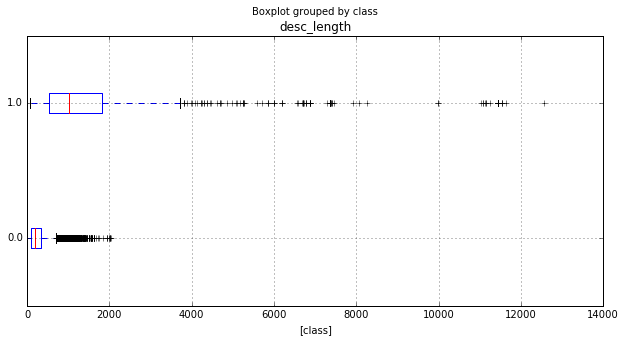

In [8]:
traincv['desc_length'] = traincv['description'].map(lambda text: len(text))
_ = traincv.boxplot(vert=False, column=['desc_length'], by=['class'], return_type='axes',figsize=(10,5))


In [9]:
traincv.groupby('class')['desc_length'].describe()

class       
0      count    10218.000000
       mean       278.841946
       std        283.720245
       min          1.000000
       25%         95.000000
       50%        185.000000
       75%        341.750000
       max       2043.000000
1      count     1281.000000
       mean      1681.684621
       std       2089.110528
       min         57.000000
       25%        530.000000
       50%       1012.000000
       75%       1829.000000
       max      12561.000000
dtype: float64

More observations:
- Skewed classes in training set (1281 spam vs 102018 ham examples)
- The character length for spam listings is higher with much wider spread. 

In [ ]:
traincv[traincv['class'] == 1].groupby(['seller_id','class']).size().sort_values(ascending=False)

** ----Output Truncated for Data Privacy Purposes---- **

#### My Feature Extraction Wish List (things I would explore further given more time)...
- Explore repeat users who spam (seems to be quite a few people - see cell above)
- Look at price distribution, there are a number of outliers (large price values) classified as spam.
    - Would also normalize price values to 0 mean and unit variance
- Seems like most "tags" are at the end of description messages. Find a way to capture this information.

For now, I'll move on...

### Text Feature Extraction
---------
-  We'll try modeling the binary classifier with a bag-of-words approach using the term frequency-inverse document frequency (TF-IDF) feature representation. 
- *Aside*: It's worth noting the TF-IDF feature vector ignores word orders that carry syntactic and semantic relationships. An RNN model could be explored here, but might not be required given structure of spam text examples and the small training dataset. 
- We'll use scikit learn's Pipeline library to extract text features (n-grams) from input and (evenually) combine features for classification.
- We'll do this now so it'll be easier for us to swap text feature extractors, feature transformations and classifiers.
- It'll also be more advantaguous during hyperparameter tuning

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.cross_validation import KFold

In [13]:
# creating pipeline of text feature extractors, transformers for classification
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    #('clf',  MultinomialNB()) ])
    ('clf',  SGDClassifier()) ])

## Model Training & Evaluation
---------
- Since the number of available training data is low, we'll avoid using using a hold-out validation set and go with k-fold cross-validation
- Selecting k=7 as the validation fold would equal ~15% of training set for each k iterations. Would like to have higher variance to start with (especially with a simple classifier) and adjust accordingly. 
-------
- First train/CV run using the product listing description text as feature (unigram) and linear classifier

In [14]:
k_fold_cv = KFold(n_folds=7, n=len(traincv))
scores = []
confusion = np.array([[0, 0], [0, 0]])
for k, (train_idx, val_idx) in enumerate(k_fold_cv):
    # training folds to fit model
    train_x = traincv.iloc[train_idx]['description'].values
    train_y = traincv.iloc[train_idx]['class'].values
    # validation fold to test model
    val_x = traincv.iloc[val_idx]['description'].values
    val_y = traincv.iloc[val_idx]['class'].values

    pipeline.fit(train_x, train_y)
    preds = pipeline.predict(val_x)

    confusion += confusion_matrix(val_y, preds)
    score = roc_auc_score(val_y, preds)
    scores.append(score)
    print("[fold {0}] ROC AUC Score: {1:.5f}".format(k,score))

print('\nTotal listings classified: {0}'.format(len(traincv)) )
print('Score: {0:.5f}'.format(sum(scores)/float(len(scores))) )
print('Confusion matrix:')
print(confusion)


[fold 0] ROC AUC Score: 0.89992
[fold 1] ROC AUC Score: 0.85355
[fold 2] ROC AUC Score: 0.85570
[fold 3] ROC AUC Score: 0.86493
[fold 4] ROC AUC Score: 0.85555
[fold 5] ROC AUC Score: 0.86817
[fold 6] ROC AUC Score: 0.86620

Total listings classified: 11499
Score: 0.86629
Confusion matrix:
[[10137    81]
 [  332   949]]


Observations:
- The result was encouraging considering: 
    - Simple bag of words model captures limited word orders which carry syntactic and semantic relationships.  
    - Only used one feature input - the *description* text field
    - Using default hyperparameter values.  
- Negative: There is a high proportion of false negatives (ham predictions that are actually spam). This will impact search relevancy.
---------
### Some important thoughts on Model Evaluation (in the context of the marketplace)
- Low recall, or sensitivity, is undesired as it would affect the marketplace buyers' search relevancy (by returning unintended spam messages to buyers' search results). 
- However, it can be argued that **precision is more important to improving user experience** (avoiding false positives - blocking seller listings that are actually ham). We wouldn't want to block legitimate listings, just to stop others from doing so. Perhaps, we should prioritize what's most important from a marketplace / company standpoint...
------
- For this exercise, I'll be using the requested ROC AUC evaluation metric. However, considering we have a skewed dataset and the points made above, it would be advantagous to leverage the *precision-recall curve*. 
- In particular, we can look for the best classifiers with *max precision(r)* where *r = recall is "acceptably high" (eg. > 0.85)*. In other words, **if we're to prioritize the buyers' user experience (through reduction of false negatives), let's select a classifier threshold with the highest precision at "acceptably high" recall value.**
- If this explanation is too complicated, we can simplify things and use the F2 score as an evaluation metric :)
- That said, the ROC AUC metric is good starting point for an assignment like this
---------
- **Note:** Evaluation metrics and its prioritization is dependant on how the model would be rolled out. Would model inference be executed during search retrieval? Or when a user submits a listing? These details would affect how we would evaluate the model's performance.
- It's also worth noting the problem could be framed differently than a binary decision problem. A ranking mechinism could be deployed (based on the posting's clarity and conciseness). 

## Hyper-parameter Tuning
-------
- We performed cross-validation using our pipeline with no changes to hyperparameters
- We'll use scikit learn's grid search library so we can train and evaluate
- Grid search CV also provides cross-validation support for free. We'll use the default 3 folds to minimize search time
- Note: searching over a subset of parameters values (previously searched over all, but did not improve results given higher model complexity)

In [15]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
}

In [16]:
spam_model = GridSearchCV(pipeline, parameters, scoring='roc_auc', n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])

train_x = traincv.description.values
train_y = traincv['class'].values
spam_model.fit(train_x, train_y)

print("Best score: %0.3f" % spam_model.best_score_)
print("Best parameters set:")
best_parameters = spam_model.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
('pipeline:', ['vectorizer', 'tfidf', 'clf'])
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  4.2min finished


Best score: 0.968
Best parameters set:
	clf__alpha: 1e-05
	clf__n_iter: 50
	clf__penalty: 'elasticnet'
	vectorizer__max_df: 0.75
	vectorizer__ngram_range: (1, 2)


In [17]:
#confusion matrix on training dataset
predictions = spam_model.predict(train_x)
cm = confusion_matrix(train_y, predictions)
cm

array([[10199,    19],
       [   25,  1256]])

#### Let's look at an example of training error

In [ ]:
error = train_x[np.not_equal(train_y,predictions)]
print("random error example: %s " % (np.random.choice(error,1)[0]) )

** ----Output Truncated for Data Privacy Purposes---- **

Quick observations:
- Combining other features to the model could improve performance
    - As seen above, incorporating description length could help
    - Increase weighting on comma or hashtag characters

### (Immediate) Further Improvements:
- Include other features (title, price, description length, misspellings) into the model pipeline. 
    - This can be achieved using FeatureUnions and Custom Transformers in scikit learn.
        - Example: Title n-gram counts to be fed into tf-idf transformer, and (normalized) price, desc_length etc. fed directly to the linear classifier. 
- Examine whether model is overfitting (first with deviance plots)
- **Due to time constraints, I'll leave this as a future exercise.**

## Scoring Model Predictions on Test Set

In [19]:
# input test_set csv for cleaning
test = clean_input(raw_test)
test_x = test.description.values
test_y = test['class'].values

In [22]:
# make predictions on test set using best model from gs
test_preds = spam_model.predict(test_x)
test_score = roc_auc_score(test_y, test_preds)
print("Test ROC AUC score: %0.5f" % test_score)
print("Classifier Statistics:\n")
print(classification_report(test_y, test_preds))

Test ROC AUC score: 0.89907
Classifier Statistics:

             precision    recall  f1-score   support

          0       0.95      0.97      0.96      1423
          1       0.90      0.83      0.86       407

avg / total       0.94      0.94      0.94      1830



## Thoughts on Production Deployments
----
- Can serialize the model to disk for use in production environments (see cell below)
- Would have to consider model monitoring (capturing classifier stats logs, required notifications etc.)
- Monitoring *"distribution drift"* 
    - If users catch on to filtering techniques, the distribution of features could change and hence the model would need to be updated accordingly. 
    - If the distribution changes rapidly, then perhaps an online learning model would be appropriate (instead of offline learning, online inference model as implemented here).
- Determine reliability requirements such as fail-over, redundancy, load-balancing etc.

In [24]:
model_file = os.path.join(file_path,'model/spam_predictor.pickle')

with open(model_file, 'wb') as fout:
    cPickle.dump(spam_model, fout)